# 量子卷積神經網絡（QCNN）教學

## 介紹
量子卷積神經網絡（Quantum Convolutional Neural Network, QCNN）是一種結合量子計算和卷積神經網絡的混合模型。這種模型利用量子計算的特性來提升神經網絡的性能。

## 目標
在本教學中，我們將介紹如何使用 Python 和 PennyLane 庫來構建一個簡單的 QCNN，並使用 CIFAR-10 資料集進行訓練和測試。

## 步驟
### 步驟 1：安裝所需庫
我們需要安裝 PennyLane 和其他一些依賴庫。

In [ ]:
!pip install pennylane pennylane-qiskit matplotlib keras

### 步驟 2：導入所需模組

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

### 步驟 3：加載並預處理 CIFAR-10 數據集

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, y_train = x_train[:10], y_train[:10]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 扁平化 CIFAR-10 圖像
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)[:, :10]
x_test = scaler.transform(x_test)[:, :10]

### 步驟 4：定義量子卷積層

In [5]:
def quantum_conv_layer(qubits, params):
    n_qubits = len(qubits)
    for i in range(n_qubits):
        qml.Rot(*params[i], wires=qubits[i])
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[qubits[i], qubits[i + 1]])

### 步驟 5：定義量子池化層

In [6]:
def quantum_pooling_layer(qubits):
    for i in range(0, len(qubits), 2):
        qml.CNOT(wires=[qubits[i], qubits[i + 1]])
        qml.RY(-np.pi / 2, wires=qubits[i + 1])
        qml.CNOT(wires=[qubits[i], qubits[i + 1]])
        qml.RY(np.pi / 2, wires=qubits[i + 1])
        qml.PauliX(wires=qubits[i + 1])

### 步驟 6：定義QCNN模型

In [7]:
n_qubits = 10  # 使用 10 個 Qubits
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def QCNN_circuit(params, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    quantum_conv_layer(range(n_qubits), params[0])
    quantum_pooling_layer(range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

### 步驟 7：定義損失函數

In [8]:
def cost(params, x, y):
    predictions = np.array(QCNN_circuit(params, x))
    return np.mean((predictions - y) ** 2)

### 步驟 8：訓練QCNN

In [9]:
params = np.random.randn(2, n_qubits, 3)
opt = qml.GradientDescentOptimizer(stepsize=0.4)
steps = 100

for i in range(steps):
    for x, y in zip(x_train, y_train):
        params = opt.step(lambda p: cost(p, x, y), params)
    if (i + 1) % 10 == 0:
        print(f"Step {i+1}, Cost: {cost(params, x_train[0], y_train[0])}")

Step 10, Cost: 0.14831812755523704
Step 20, Cost: 0.11019011516334179
Step 30, Cost: 0.11010735685527481
Step 40, Cost: 0.1101094544396111
Step 50, Cost: 0.11010955547363395
Step 60, Cost: 0.11010944444525321
Step 70, Cost: 0.11010931689123862
Step 80, Cost: 0.11010918713118327
Step 90, Cost: 0.11010905608050503
Step 100, Cost: 0.11010892378868589


### 步驟 9：測試QCNN

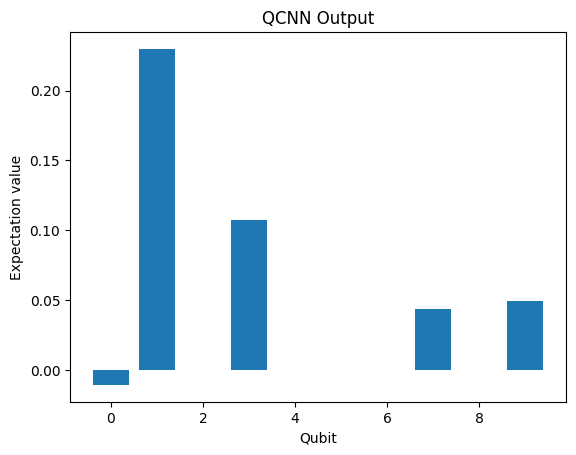

In [10]:
test_results = [QCNN_circuit(params, x) for x in x_test[:10]]
plt.bar(range(n_qubits), np.mean(test_results, axis=0))
plt.xlabel('Qubit')
plt.ylabel('Expectation value')
plt.title('QCNN Output')
plt.show()